# Detecting Blindness with Deep Learning
> Using CNNs to detect diabetic retinopathy in retina photos


# INTRODUCTION

Diabetic retinopathy (DR) is one of the leading causes of vision loss. The World Health Organization reports that more than 300 million people worldwide have diabetes (Wong et al. 2016). In 2019, the global prevalence of DR among individuals with diabetes was at more than 25% (Thomas et al. 2019). The prevalence has been rising rapidly in developing countries.

Early detection and treatment are crucial steps towards preventing DR. The screening procedure requires a trained clinical expert to examine the fundus photographs of the patient's retina. This creates delays in diagnosis and treatment. This is especially relevant for developing countries, which often lack qualified medical staff to perform the diagnosis. Automated detection of DR can speed up the efficiency and coverage of the screening programs.

![](https://github.com/kozodoi/website/blob/master/_notebooks/images/fig_retina.jpeg?raw=1)

Image source: https://www.eyeops.com/contents/our-services/eye-diseases/diabetic-retinopathy

## Data exploration

The data set is available for the download at the [competition's website](https://www.kaggle.com/c/aptos2019-blindness-detection/data). The data includes 3,662 labeled retina images of clinical patients and a test set with 1,928 images with unknown labels. 

The images are labeled by a clinical expert. The integer labels indicate the severity of DR on a scale from 0 to 4, where 0 indicates no disease and 5 is the proliferative stage of DR.

Let's start by importing the data and looking at the class distribution.

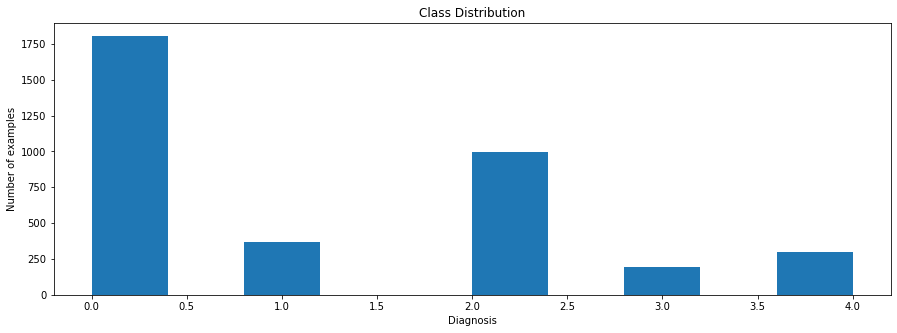

In [ ]:
#collapse-hide

##### PACKAGES

import numpy as np
import pandas as pd

import torch
import torchvision

from torchvision import transforms, datasets
from torch.utils.data import Dataset

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from tqdm import tqdm_notebook as tqdm

import random
import time
import sys
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


##### CLASS DISTRIBUTION

# import data
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test  = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

# plot
fig = plt.figure(figsize = (15, 5))
plt.hist(train['diagnosis'])
plt.title('Class Distribution')
plt.ylabel('Number of examples')
plt.xlabel('Diagnosis')

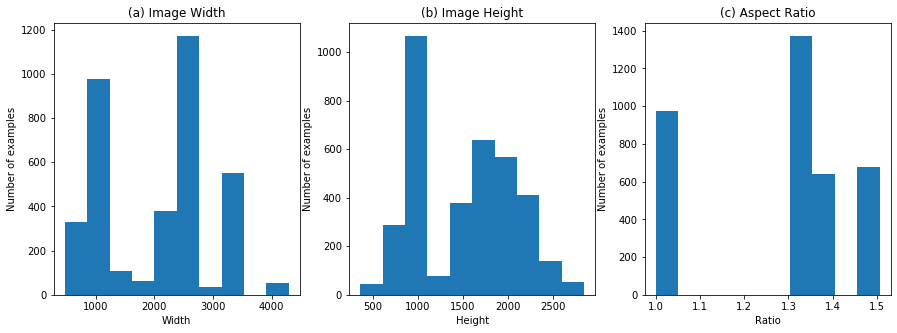

In [ ]:
#collapse-hide

# placeholder
image_stats = []

# import loop
for index, observation in tqdm(train.iterrows(), total = len(train)):
    
    # import image
    img = cv2.imread('../input/aptos2019-blindness-detection/train_images/{}.png'.format(observation['id_code']))

    # compute stats
    height, width, channels = img.shape
    ratio = width / height
    
    # save
    image_stats.append(np.array((observation['diagnosis'], height, width, channels, ratio)))

# construct DF
image_stats = pd.DataFrame(image_stats)
image_stats.columns = ['diagnosis', 'height', 'width', 'channels', 'ratio']

# create plot 
fig = plt.figure(figsize = (15, 5))

# width
plt.subplot(1, 3, 1)
plt.hist(image_stats['width'])
plt.title('(a) Image Width')
plt.ylabel('Number of examples')
plt.xlabel('Width')

# height
plt.subplot(1, 3, 2)
plt.hist(image_stats['height'])
plt.title('(b) Image Height')
plt.ylabel('Number of examples')
plt.xlabel('Height')

# ratio
plt.subplot(1, 3, 3)
plt.hist(image_stats['ratio'])
plt.title('(c) Aspect Ratio')
plt.ylabel('Number of examples')
plt.xlabel('Ratio')

In [ ]:
#collapse-hide

##### DATASET

# image preprocessing
def prepare_image(path, image_size = 256):
    
    # import
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resize
    image = cv2.resize(image, (int(image_size), int(image_size)))

    # convert to tensor    
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image
   
# dataset
class EyeData(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + '.png')
        image    = prepare_image(img_name)  
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}
    
    
##### EXAMINE SAMPLE BATCH

# transformations
sample_trans = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])

# dataset
sample = EyeData(data       = train, 
                 directory  = '../input/aptos2019-blindness-detection/train_images',
                 transform  = sample_trans)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = 10, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (15, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, len(labels)/2, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

![](https://github.com/kozodoi/website/blob/master/_notebooks/images/fig_eye_example.png?raw=1)


## Image preprocessing



In [ ]:
#collapse-show

### image preprocessing function
def prepare_image(path, sigmaX = 10, do_random_crop = False):
    
    # import image
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # perform smart crops
    image = crop_black(image, tol = 7)
    if do_random_crop == True:
        image = random_crop(image, size = (0.9, 1))
    
    # resize and color
    image = cv2.resize(image, (int(image_size), int(image_size)))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    
    # circular crop
    image = circle_crop(image, sigmaX = sigmaX)

    # convert to tensor    
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image


### automatic crop of black areas
def crop_black(img, tol = 7):
    
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        
        if (check_shape == 0): 
            return img 
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img  = np.stack([img1, img2, img3], axis = -1)
            return img
        
        
### circular crop around center
def circle_crop(img, sigmaX = 10):   
        
    height, width, depth = img.shape
    
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape
    
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness = -1)
    
    img = cv2.bitwise_and(img, img, mask = circle_img)
    return img 


### random crop
def random_crop(img, size = (0.9, 1)):

    height, width, depth = img.shape
    
    cut = 1 - random.uniform(size[0], size[1])
    
    i = random.randint(0, int(cut * height))
    j = random.randint(0, int(cut * width))
    h = i + int((1 - cut) * height)
    w = j + int((1 - cut) * width)

    img = img[i:h, j:w, :]    
    
    return img

In [ ]:
#collapse-show

##### DATASET
    
# dataset class
class EyeData(Dataset):

    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + '.png')
        image    = prepare_image(img_name)  
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}


##### EXAMINE SAMPLE BATCH

image_size = 256


# transformations
sample_trans = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])

# dataset
sample = EyeData(data       = train, 
                 directory  = '../input/aptos2019-blindness-detection/train_images',
                 transform  = sample_trans)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = 10, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (15, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, len(labels)/2, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

![](https://github.com/kozodoi/website/blob/master/_notebooks/images/fig_eye_fixed.png?raw=1)


# 4. Modeling



![](https://github.com/kozodoi/website/blob/master/_notebooks/images/fig_imagenet.png?raw=1)


## Pre-training

In [ ]:
#collapse-show

# GPU check
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
    device = torch.device('cpu')
else:
    print('CUDA is available. Training on GPU...')
    device = torch.device('cuda:0')

# set seed
def seed_everything(seed = 23):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed = 23
seed_everything(seed)

CUDA is available. Training on GPU...


Let's take a quick look at the class distribution in the 2015 data.

In [ ]:
#collapse-show

# import data
train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
train.columns = ['id_code', 'diagnosis']
test = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['diagnosis'].value_counts(normalize = True))
print('-' * 15)
print(test['diagnosis'].value_counts(normalize = True))

(35126, 2) (3662, 2)
---------------
0    0.734783
2    0.150658
1    0.069550
3    0.024853
4    0.020156
Name: diagnosis, dtype: float64
---------------
0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: diagnosis, dtype: float64


The imbalance in the source data is stronger than in the target data: 73% of images represent healthy patients, whereas the most severe stage of the DR is only found in 2% of the images. To address the imbalance, we will use the target data set as a validation sample during training.

We create two `Dataset` objects to enable different augmentations on training and inference stages: `EyeTrainData` and `EyeTestData`. The former includes a random crop that is skipped for the test data.

In [ ]:
#collapse-hide
  
# dataset class: train
class EyeTrainData(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + '.jpeg')
        image    = prepare_image(img_name, do_random_crop = True)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}
    
    
# dataset class: test
class EyeTestData(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + '.png')
        image    = prepare_image(img_name, do_random_crop = False)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}

In [ ]:
#collapse-show

# parameters
batch_size = 20
image_size = 256

# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor()
                                 ])

# validation transformations
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])

# create datasets
train_dataset = EyeTrainData(data      = train, 
                             directory = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                             transform = train_trans)
valid_dataset = EyeTestData(data       = test, 
                            directory  = '../input/aptos2019-blindness-detection/train_images',
                            transform  = valid_trans)

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = True, 
                                           num_workers = 4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = False, 
                                           num_workers = 4)

In [ ]:
#collapse-show

# model name
model_name = 'enet_b4'

# initialization function
def init_model(train = True):
    
    ### training mode
    if train == True:
                 
        # load pre-trained model
        model = EfficientNet.from_pretrained('efficientnet-b4', num_classes = 5)
      
        
    ### inference mode
    if train == False:
        
        # load pre-trained model
        model = EfficientNet.from_name('efficientnet-b4')
        model._fc = nn.Linear(model._fc.in_features, 5)

        # freeze  layers
        for param in model.parameters():
            param.requires_grad = False
            
    return model


# check architecture
model = init_model()
print(model)

In [ ]:
#collapse-show

# loss function
criterion = nn.CrossEntropyLoss()

# epochs
max_epochs = 15
early_stop = 5

# learning rates
eta = 1e-3

# scheduler
step  = 5
gamma = 0.5

# optimizer
optimizer = optim.Adam(model.parameters(), lr = eta)
scheduler = lr_scheduler.StepLR(optimizer, step_size = step, gamma = gamma)

# initialize model and send to GPU
model = init_model()
model = model.to(device)

In [ ]:
#collapse-show

# placeholders
oof_preds = np.zeros((len(test), 5))
val_kappas = []
val_losses = []
trn_losses = []
bad_epochs = 0

# timer
cv_start = time.time()

# training and validation loop
for epoch in range(max_epochs):

    ##### PREPARATION

    # timer
    epoch_start = time.time()

    # reset losses
    trn_loss = 0.0
    val_loss = 0.0

    # placeholders
    fold_preds = np.zeros((len(test), 5))


    ##### TRAINING

    # switch regime
    model.train()

    # loop through batches
    for batch_i, data in enumerate(train_loader):

        # extract inputs and labels
        inputs = data['image']
        labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)
        optimizer.zero_grad()

        # forward and backward pass
        with torch.set_grad_enabled(True):
            preds = model(inputs)
            loss  = criterion(preds, labels)
            loss.backward()
            optimizer.step()

        # compute loss
        trn_loss += loss.item() * inputs.size(0)
        
        
    ##### INFERENCE

    # switch regime
    model.eval()
    
    # loop through batches
    for batch_i, data in enumerate(valid_loader):
        
        # extract inputs and labels
        inputs = data['image']
        labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)

        # compute predictions
        with torch.set_grad_enabled(False):
            preds = model(inputs).detach()
            fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = preds.cpu().numpy()

        # compute loss
        loss      = criterion(preds, labels)
        val_loss += loss.item() * inputs.size(0)
        
    # save predictions
    oof_preds = fold_preds

    # scheduler step
    scheduler.step()


    ##### EVALUATION

    # evaluate performance
    fold_preds_round = fold_preds.argmax(axis = 1)
    val_kappa = metrics.cohen_kappa_score(test['diagnosis'], fold_preds_round.astype('int'), weights = 'quadratic')

    # save perfoirmance values
    val_kappas.append(val_kappa)
    val_losses.append(val_loss / len(test))
    trn_losses.append(trn_loss / len(train))


    ##### EARLY STOPPING

    # display info
    print('- epoch {}/{} | lr = {} | trn_loss = {:.4f} | val_loss = {:.4f} | val_kappa = {:.4f} | {:.2f} min'.format(
        epoch + 1, max_epochs, scheduler.get_lr()[len(scheduler.get_lr()) - 1],
        trn_loss / len(train), val_loss / len(test), val_kappa,
        (time.time() - epoch_start) / 60))

    # check if there is any improvement
    if epoch > 0:       
        if val_kappas[epoch] < val_kappas[epoch - bad_epochs - 1]:
            bad_epochs += 1
        else:
            bad_epochs = 0

    # save model weights if improvement
    if bad_epochs == 0:
        oof_preds_best = oof_preds.copy()
        torch.save(model.state_dict(), '../models/model_{}.bin'.format(model_name))

    # break if early stop
    if bad_epochs == early_stop:
        print('Early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
            np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
        print('')
        break

    # break if max epochs
    if epoch == (max_epochs - 1):
        print('Did not met early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
            np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
        print('')
        break
        
# load best predictions
oof_preds = oof_preds_best

# print performance
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

Loaded pretrained weights for efficientnet-b4
- epoch 1/15 | lr = 0.001 | trn_loss = 0.7140 | val_loss = 1.3364 | val_kappa = 0.7268 | 30.03 min
- epoch 2/15 | lr = 0.001 | trn_loss = 0.6447 | val_loss = 1.0670 | val_kappa = 0.8442 | 27.19 min
- epoch 3/15 | lr = 0.001 | trn_loss = 0.6203 | val_loss = 0.7667 | val_kappa = 0.7992 | 27.21 min
- epoch 4/15 | lr = 0.001 | trn_loss = 0.6020 | val_loss = 0.7472 | val_kappa = 0.8245 | 27.68 min
- epoch 5/15 | lr = 0.00025 | trn_loss = 0.5899 | val_loss = 0.7720 | val_kappa = 0.8541 | 29.42 min
- epoch 6/15 | lr = 0.0005 | trn_loss = 0.5542 | val_loss = 0.9255 | val_kappa = 0.8682 | 29.33 min
- epoch 7/15 | lr = 0.0005 | trn_loss = 0.5424 | val_loss = 0.8917 | val_kappa = 0.8763 | 29.91 min
- epoch 8/15 | lr = 0.0005 | trn_loss = 0.5359 | val_loss = 0.9555 | val_kappa = 0.8661 | 30.70 min
- epoch 9/15 | lr = 0.0005 | trn_loss = 0.5252 | val_loss = 0.8642 | val_kappa = 0.8778 | 28.76 min
- epoch 10/15 | lr = 0.000125 | trn_loss = 0.5184 | val_l

Training on the Kaggle GPU-enabled machine took us about 7 hours! Let's visualize the training and validation loss dynamics.

In [ ]:
#collapse-show

# plot size
fig = plt.figure(figsize = (15, 5))

# plot loss dynamics
plt.subplot(1, 2, 1)
plt.plot(trn_losses, 'red',   label = 'Training')
plt.plot(val_losses, 'green', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot kappa dynamics
plt.subplot(1, 2, 2)
plt.plot(val_kappas, 'blue', label = 'Kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa')
plt.legend()

![](https://github.com/kozodoi/website/blob/master/_notebooks/images/fig_loss_pre_training.png?raw=1)

The cross-entropy loss on the validation set reaches minimum already after 3 epochs. At the same time, kappa continues to increase up to the 15th epoch. Since we use kappa to evaluate the quality of our solution, we save weights after 15 epochs.

We also construct a confusion matrix of the trained model. The numbers in the cells are percentages. According to the results, the model does a poor job in distinguishing the mild and moderate stages of DR: 86% of images with mild DR are classified as moderate. The best performance is observed for healthy patients. Overall, we see that the model tends to confuse nearby severity stages but rarely misclassifies the proliferate and mild stages.

![](https://github.com/kozodoi/website/blob/master/_notebooks/images/fig_cm_pre_training.png?raw=1)